In [53]:
import matplotlib.pyplot as plt
import numpy as np

contents = None
with open("log_2.txt", "r") as f:
    contents = [ i for i in f.readlines() if i.startswith("FOUND") ]

bugs_simreq = []
bugs_dse = []
difference = []
for line in contents:
    dse, simreq = float(line[6:11]), float(line[12:17])
    bugs_dse.append(dse)
    bugs_simreq.append(simreq)
    difference.append(simreq - dse)

In [83]:
bugsupper = int(max(max(bugs_simreq), max(bugs_dse))) + 1
occurences_map = {
    (i, j, len([
        None for index in range(len(difference))
        if (bugs_simreq[index] == i) and (bugs_dse[index] == j)
    ]))
    for i in range(0, bugsupper)
    for j in range(0, bugsupper)
}
occurences = np.zeros(shape=(bugsupper, bugsupper))
for i, j, v in occurences_map:
    occurences[i][j] = np.log2(v + 1)

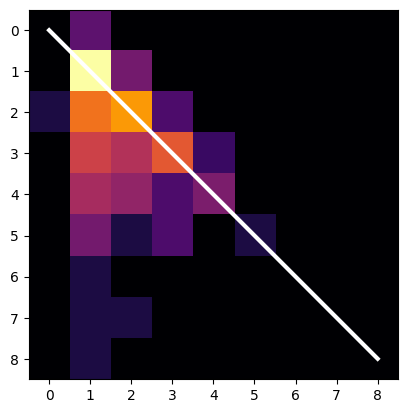

In [92]:
plt.imshow(occurences, cmap="inferno", aspect="equal")
plt.xticks(np.arange(0, bugsupper))
plt.yticks(np.arange(0, bugsupper))
plt.plot([0, bugsupper-1], [0, bugsupper-1], color="white", linewidth=3)
None

(array([ 15., 584.,  84.,  41.,   0.,  15.,   6.,   2.,   1.,   1.]),
 array([-1. , -0.2,  0.6,  1.4,  2.2,  3. ,  3.8,  4.6,  5.4,  6.2,  7. ]),
 <BarContainer object of 10 artists>)

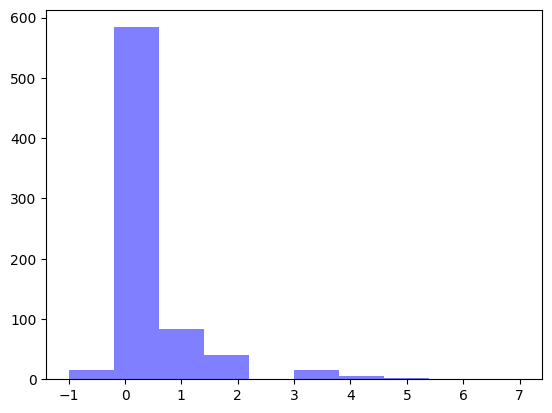

In [35]:
plt.hist(difference, color="blue", alpha=0.5)

In [38]:
import scipy.stats as stats

In [39]:
ttest_result = stats.ttest_1samp(difference, 0., alternative="greater")
ttest_result

TtestResult(statistic=10.35310264399531, pvalue=7.231411168680877e-24, df=748)